# SOAR-4m Goodman Spectrograph Quick-Reduce Notebook

### 0. Background

This notebook will do a quick-and-dirty processing, wavelength calibration, and spectrophotometic calibration of a spectrum obtained with the SOAR-4m Goodman Spectrograph, using just an observed spectrum of an Hamuy Tertiary Standard Star (for spectrophotometric calibration) and an observed spectrum of the target object taken with the same Goodman configuration (e.g., the 400_WD mode, binned 2x2). No bias frames or flat fields are required for this quick-and-dirty processing. (A single wavecal frame is needed merely to identify a single line and its corresponding column and wavelength, for a rough wavelength calibration.)  

_Thus, this notebook is intended for quick, on-the-fly by-eye classification of a (roughly) calibrated spectrum at the telescope.  As such, it tries to fit into a niche between running IRAF implot at the telescope and running a full processing and calibration of the spectrum afterwards._


#### 0.a  Hamuy Tertiary Standards

The Hamuy Tertiary Standards and their coordinates can be found here: http://www.ctio.noao.edu/soar/content/hamuy-spectrophotometric-standards .

A Look-up Table that translates from the Hamuy Tertiary Standard Star Name and the corresponding IRAF File name that contains the star's spectrophotometricly calibrated SED can be found below.



** Look-up Table:  Hamuy Tertiary Standard Star Names to IRAF Calibrated Spectrum Filenames **

| Star Name   | IRAF File | Comments |
| ----------  | --------- | -------- |
| CD-32 9927  | cd32.dat  |          |
| CD-34 241   | l377.dat  | CD-34 241 is mistakenly named LTT 377 in Stone & Baldwin (1983) and in Hamuy et al. (1992 & 1994) |          
| EG 21       | eg21.dat  |          |            
| EG 274      | eg274.dat |          |          
| Feige 56    | f56.dat   |          |           
| Feige 110   | f110.dat  |          |          
| Hiltner 600 | h600.dat  |          |          
| LTT 745     | l745.dat  | Not on SOAR list of Hamuy Tertiary Standards |
| LTT1020     | l1020.dat |          |         
| LTT 1788    | l1788.dat |          |         
| LTT 2415    | l2415.dat |          |         
| LTT 3218    | l3218.dat |          |         
| LTT 3864    | l3864.dat |          |         
| LTT 4364    | l4364.dat |          |         
| LTT 4816    | l4816.dat |          |         
| LTT 6248    | l6248.dat |          |         
| LTT 7379    | l7379.dat |          |         
| LTT 7987    | l7987.dat |          |
| LTT 9239    | l9239.dat |          |
| LTT 9491    | l9491.dat |          |


#### 0.b  Quick-and-Dirty Wavelength Calibration

It is assumed that the spectrum bin to wavelength conversion is linear,
and that the spectrum is parallel to the rows in the observed 2D spectrum.
These assumptions appear to hold well enough for the Goodman.

Thus,
<pre>
dispersion = (wave2-wave1)/(col2-col1)
wavelength0 = wave1 - dispersion*col1
where wave1, wave2 are wavelengths 1 and 2, and 
      col1, col2   are the column positions (in pixels) 
                   corresponding to wave1, wave2, respectively.
</pre>
The Goodman grating dispersions appear to be pretty constant over time;
so, to find wavelength0, one really only need to identify a single line 
(and its wavelength, wave1) from a single wavecal comparison arc spectrum 
and measure its column pixel value (col1); this  should be done nightly, 
or whenever there has been a configuration change.

![](../plots/Quick_and_Dirty_Wavelength_Calibration.png)

(Note:  a higher resolution image of the bottom plot can be found 
[here](../plots/goodman_wd400_hgarne.png "here").)

In this case, you would want to edit the values of col1 and wave1 
in Section 2.b below to be "col1=1190." and "wave1=5460.7".


### 1.  Initial Setup

In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
from scipy import interpolate
import glob
import math
import os
import matplotlib.pyplot as plt

# pysynphot directory and module (deprecated now in this notebook)...
## We only use the pysynphot functions, not the pysynphot database, 
##  so we set PYSYN_CDBS to a dummy value to avoid scary warning messages...
##os.environ['PYSYN_CDBS'] = '/Users/dtucker/IRAF/SynphotData/grp/hst/cdbs/'
#os.environ['PYSYN_CDBS'] = '/dummy/'
#import pysynphot as S

%matplotlib inline


### 2.  User Inputs

#### 2.a. Change Rarely (if Ever):

In [2]:
# Goodman configuration info...
#  Un-binned spectral dispersion, in Angstroms/pixel, for defined Goodman gratings...
#  (From http://www.ctio.noao.edu/soar/sites/default/files/GOODMAN/Images/New_Goodman_Cheat_Sheet.pdf)
dispersion_nonbinned = {400:1.0, 600:0.65, 930:0.42, 1200:0.31, 1800:0.19, 2100:0.15, 2400:0.12}


# Standard star spectrum info...
#  Observed spectrum:
#   Window (in pixels) around the center row value for calculations 
#   (ss_delta_aper_row) and for plotting (ss_delta_plot_row):
ss_delta_aper_row = 5    # Integer value
ss_delta_plot_row = 50   # Integer value
#  IRAF calibration file directory:
ss_irafCalDir='../data/ctionewcal'


# Target spectrum info...
#   Window (in pixels) around the center row value for calculations 
#   (ss_delta_aper_row) and for plotting (ss_delta_plot_row):
t_delta_aper_row = 5
t_delta_plot_row = 50

#### 2.b.  Change Often (Nightly or Per Target):

In [3]:
# Goodman configuration info...
# Typically change nightly or whenever there has been a configuration change:
#  Grating:
grating = 400      # Integer value
#  Binning in wavelength direction (e.g., binSize_wave = 2 for 2x2 binning):
binSize_wave = 2   # Integer value
# column pixel value (col1) and corresponding wavelength (wave1) 
#  for an identified line in wavecal comparison lamp spectrum:
col1 = 1190.       # In pixels
wave1 = 5460.7348  # In Angstroms


# Standard star spectrum info...
# Typically change nightly or whenever there has been a configuration change:
#  Observed spectrum file:
ss_inputFile='/Users/dtucker/Desktop/ReductionsTemp/SOAR-Sep28-Oct03-2018-Run/2018-09-30/0129_feige110.fits'
#  Center row along which the standard star spectrum lies within ss_inputFile:
ss_aper_row_center = 455   # Integer value 
#  Name of the IRAF file containing the spectrophometrically 
#   calibrated SED for this standard star within the ss_irafCalDir
#   directory defined above (in "2.b. Change Rarely (if Ever)"):
ssFile_short = 'f110.dat'   


# Target spectrum info...
# Typically change per target...
t_inputFile='/Users/dtucker/Desktop/ReductionsTemp/SOAR-Sep28-Oct03-2018-Run/2018-10-01/0325_obj1208.fits'
#  Center row along which the target object's spectrum lies within t_inputFile:
t_aper_row_center = 475

### 3.  Standard Star Spectrum

Just need to do this once per night.  The instrumental response is saved to a calibration file, and, as long as the Goodman configuration is not changed, the same calibration can be used for all the targets taken that night.

('Min:', 629)
('Max:', 53641)
('Mean:', 641.6852231030485)
('Stdev:', 52.4005623586233)
[3080.7348 3082.7348 3084.7348 ... 7216.7348 7218.7348 7220.7348]
[0. 0. 0. ... 0. 0. 0.]


* * * Spectrophotometric calibration written to /Users/dtucker/Desktop/ReductionsTemp/SOAR-Sep28-Oct03-2018-Run/2018-09-30/0129_feige110.fits.calib.csv * * *




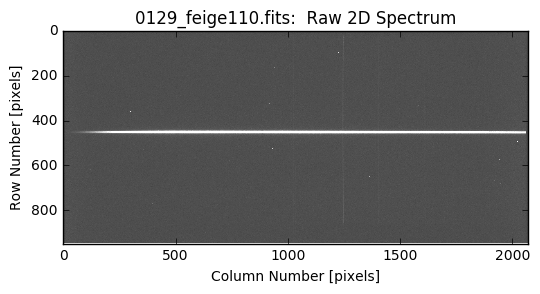

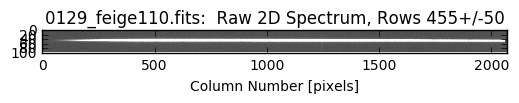

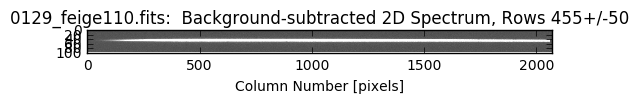

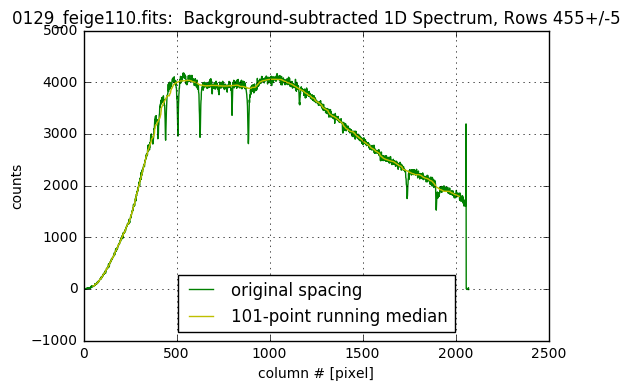

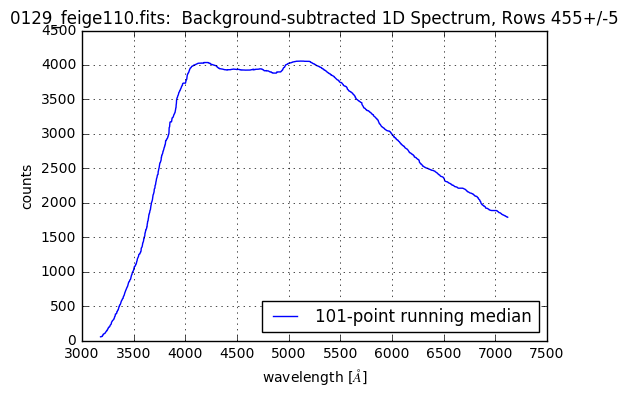

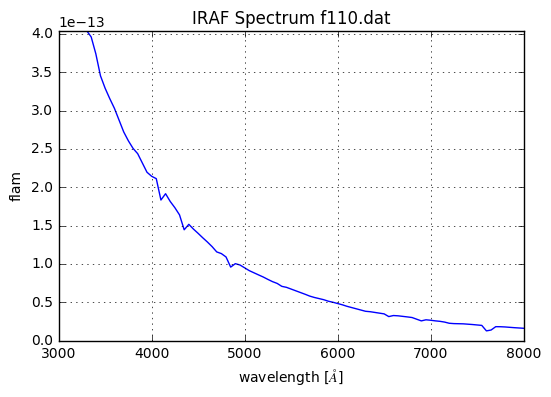

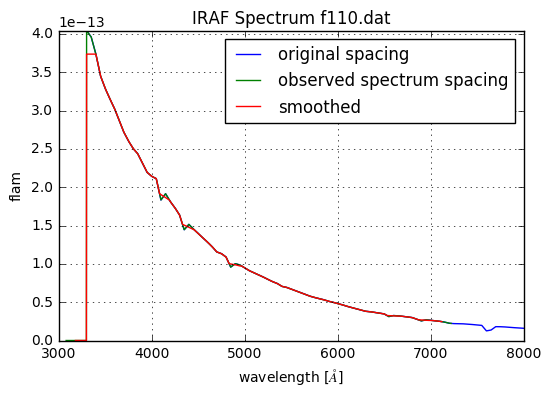

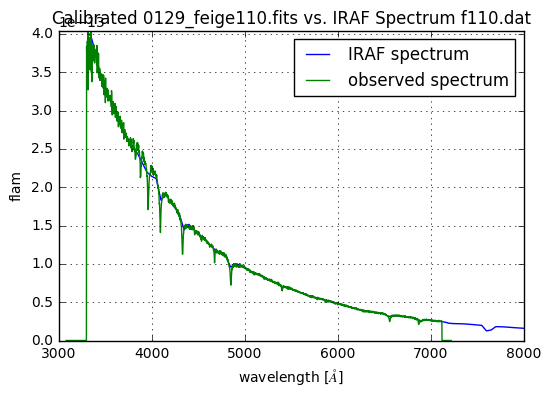

In [4]:
############################################################################
#
# Deal with Goodman configuration...
#
#############################################################################

# Effective dispersion for this grating and binning...
dispersion = binSize_wave*dispersion_nonbinned[grating]
# Wavelength corresponding to spectrum bin 0:
wavelength0 = wave1 - dispersion*col1  # Will typically be around 3100 for "400_WD" configuration


#############################################################################
#
# Deal with observed spectrum...
#
#############################################################################

inputFile = ss_inputFile
outputFile = ss_inputFile+'.calib.csv'

aper_row_min = ss_aper_row_center - ss_delta_aper_row
aper_row_max = ss_aper_row_center + ss_delta_aper_row
small_plot_row_min = ss_aper_row_center - ss_delta_plot_row
small_plot_row_max = ss_aper_row_center + ss_delta_plot_row

image_data = fits.getdata(inputFile)

print('Min:', np.min(image_data))
print('Max:', np.max(image_data))
print('Mean:', np.mean(image_data))
print('Stdev:', np.std(image_data))

vmin = np.mean(image_data) - np.std(image_data)
vmax = np.mean(image_data) + 2.*np.std(image_data)

plt.figure(1)
plt.imshow(image_data, cmap='gray', vmin=vmin, vmax=vmax)
plt.xlabel("Column Number [pixels]")
plt.ylabel("Row Number [pixels]")
title="""%s:  Raw 2D Spectrum""" % (os.path.basename(inputFile))
plt.title(title)

plt.figure(2)
plt.imshow(image_data[small_plot_row_min:small_plot_row_max,:], 
           cmap='gray', vmin=vmin, vmax=vmax)
plt.xlabel("Column Number [pixels]")
title="""%s:  Raw 2D Spectrum, Rows %d+/-%d""" % \
    (os.path.basename(inputFile), ss_aper_row_center, ss_delta_plot_row)
plt.title(title)

median1d = np.median(image_data[small_plot_row_min:small_plot_row_max,:],axis=0)

bkg_data = np.tile(median1d,[948,1])

new_image_data = image_data-bkg_data

vmin = 0.00 - np.std(image_data)
vmax = 0.00 + 2.*np.std(image_data)


plt.figure(3)
plt.imshow(new_image_data[small_plot_row_min:small_plot_row_max,:], 
           cmap='gray', vmin=vmin, vmax=vmax)
plt.xlabel("Column Number [pixels]")
title="""%s:  Background-subtracted 2D Spectrum, Rows %d+/-%d""" % \
    (os.path.basename(inputFile), ss_aper_row_center, ss_delta_plot_row)
plt.title(title)


sum1d = np.sum(new_image_data[aper_row_min:aper_row_max,:],axis=0)

#x=np.arange(0,2071)
x=np.arange(0,sum1d.size)

# Running median...
x_series = pd.Series(x, name='x')
sum1d_series = pd.Series(sum1d, name='counts')
df_sum1d = pd.concat([x_series,sum1d_series], axis=1)
df_sum1d.loc[:,'wavelength'] = dispersion*df_sum1d.loc[:,'x'] + wavelength0
wave = df_sum1d.wavelength.values
df_sum1d_smoothed = df_sum1d.rolling(101).median().dropna()
x_smoothed = df_sum1d_smoothed.x.values
wave_smoothed = df_sum1d_smoothed.wavelength.values
sum1d_smoothed = df_sum1d_smoothed.counts.values


plt.figure(4)
plt.plot(x, sum1d, 'g-', 
         x_smoothed, sum1d_smoothed, 'y-')
plt.legend(['original spacing', 
            '101-point running median'], 
           loc='best')
plt.xlabel("""column # [pixel]""")
plt.ylabel("counts")
title="""%s:  Background-subtracted 1D Spectrum, Rows %d+/-%d""" % \
    (os.path.basename(inputFile), ss_aper_row_center, ss_delta_aper_row)
plt.title(title)
plt.grid(True)

plt.figure(5)
plt.plot(wave_smoothed, sum1d_smoothed, 'b-')
plt.legend(['101-point running median'], 
           loc='best')
plt.xlabel("""wavelength [$\AA$]""")
plt.ylabel("counts")
title="""%s:  Background-subtracted 1D Spectrum, Rows %d+/-%d""" % \
    (os.path.basename(inputFile), ss_aper_row_center, ss_delta_aper_row)
plt.title(title)
plt.grid(True)



#############################################################################
#
# Deal with IRAF spectrum...
#
#############################################################################

# IRAF file...
#   Read in IRAF file...
ssFile = os.path.join(ss_irafCalDir, ssFile_short)
df_ss_orig = pd.read_csv(ssFile, \
                         header=None, \
                         delim_whitespace=True, \
                         comment='#', \
                         names=['wave','abmag','wave_binsize'])

#   pysynphot method (deprecated now in this notebook)...
#ssSpectrum = S.ArraySpectrum(df_ss_orig['wave'].values,df_ss_orig['abmag'].values,name=ssFile_short,fluxunits='abmag')
#ssSpectrum.convert('flam')

#   pandas/numpy method...
#   Convert ABmags to Fnu...
df_ss_orig.loc[:,'fnu'] = np.power(10.,-0.4*(df_ss_orig.loc[:,'abmag']+48.60))
#   Convert Fnu to Flam...
c_kms = 299792.5        # speed of light in km/s
c_ms = 1000.*c_kms      # speed of light in m/s
c_as = (1.000e10)*c_ms  # speed of light in Angstroms/sec
df_ss_orig.loc[:,'flam'] = df_ss_orig.loc[:,'fnu'] * c_as / (df_ss_orig.loc[:,'wave'] * df_ss_orig.loc[:,'wave'])
ssSpectrum = df_ss_orig

wavelo = 3000.
wavehi = 8000.
mask = ( (ssSpectrum.wave >= wavelo) & (ssSpectrum.wave <= wavehi) )
fluxhi = ssSpectrum.flam[mask].max()

plt.figure(6)
plt.plot(ssSpectrum.wave.values, ssSpectrum.flam.values)
plt.xlim(wavelo, wavehi)
plt.ylim(0.00,fluxhi)
plt.xlabel("""wavelength [$\AA$]""")
plt.ylabel('flam')
title="""IRAF Spectrum %s""" % (ssFile_short)
plt.title(title)
plt.grid(True)


ss_interp = interpolate.interp1d(ssSpectrum.wave.values, ssSpectrum.flam.values, 
                                 bounds_error=False, fill_value=0., 
                                 kind='linear')


flux_series = pd.Series(ss_interp(df_sum1d.wavelength), name='flam')
df_ss = pd.concat([df_sum1d.x,flux_series,df_sum1d.wavelength], axis=1)


# Running median...
df_ss_smoothed = df_ss.rolling(101).median().dropna()


plt.figure(7)
plt.plot(ssSpectrum.wave.values, ssSpectrum.flam.values, 'b-', 
         wave, ss_interp(wave), 'g-', 
        df_ss_smoothed.wavelength.values, df_ss_smoothed.flam.values, 'r-')
plt.legend(['original spacing', 
            'observed spectrum spacing',
            'smoothed'], 
           loc='best')
plt.xlim(wavelo, wavehi)
plt.ylim(0.00,fluxhi)
plt.xlabel("""wavelength [$\AA$]""")
plt.ylabel('flam')
title="""IRAF Spectrum %s""" % (ssFile_short)
plt.title(title)
plt.grid(True)


df_ss_smoothed.loc[:,'ratio'] = df_ss_smoothed.loc[:,'flam'] / df_sum1d_smoothed.loc[:,'counts'] 
ratio_median = df_ss_smoothed.ratio.median()
df_ss_smoothed.loc[:,'rel_scale'] = df_ss_smoothed.loc[:,'ratio'] / ratio_median


calib_interp = interpolate.interp1d(df_ss_smoothed.wavelength.tolist(), 
                                    df_ss_smoothed.ratio.tolist(),  
                                     bounds_error=False, fill_value=0., 
                                     kind='linear')

print wave
print calib_interp(wave)

# problem here?:
df_sum1d.loc[:,'Flam'] =  df_sum1d.loc[:,'counts'] * calib_interp(wave)


plt.figure(8)
plt.plot(ssSpectrum.wave.values, ssSpectrum.flam.values, 'b-', 
        df_sum1d.wavelength.values, df_sum1d.Flam.values, 'g-')
plt.legend(['IRAF spectrum', 
            'observed spectrum'],
           loc='best')
plt.xlim(wavelo, wavehi)
plt.ylim(0.00,fluxhi)
plt.xlabel("""wavelength [$\AA$]""")
plt.ylabel('flam')
title="""Calibrated %s vs. IRAF Spectrum %s""" % \
    (os.path.basename(inputFile), ssFile_short)
plt.title(title)
plt.grid(True)


wave_series = pd.Series(wave, name='wave')
calib_series = pd.Series(calib_interp(wave), name='calib')
df_calib = pd.concat([wave_series,calib_series], axis=1)
df_calib.to_csv(outputFile,index=False)

print 
print
print """* * * Spectrophotometric calibration written to %s * * *""" % (outputFile)
print
print

### 4.  Target Object Spectrum

Run this section for each new target spectrum.  

Generally, you will run the Standard Star Spectrum once per night (preferably at the beginning of the night), and you will run the Target Object Spectrum section multiple times per night (changing the target spectrum info in the User Inputs section above as needed).

Note that the code for the Target Object Spectrum is nearly identical to that for the Standard Star Spectrum.

('Min:', 630)
('Max:', 56558)
('Mean:', 642.0507923362)
('Stdev:', 124.01303836346364)


* * * Calibrated 1d Spectrum written to /Users/dtucker/Desktop/ReductionsTemp/SOAR-Sep28-Oct03-2018-Run/2018-10-01/0325_obj1208.fits.1d_calib.csv * * *




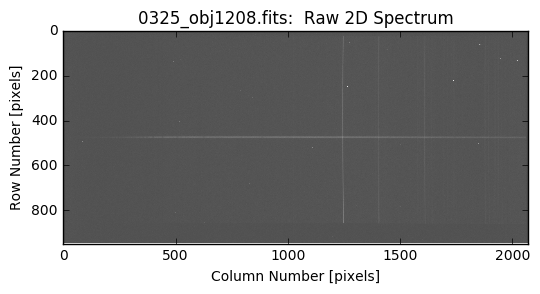

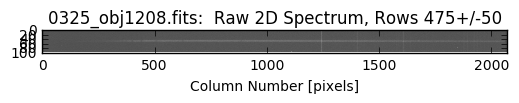

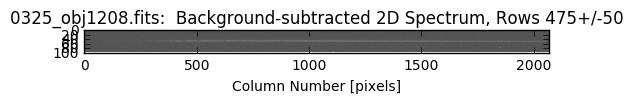

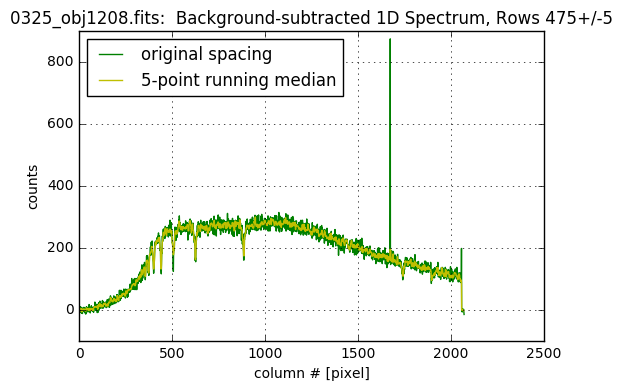

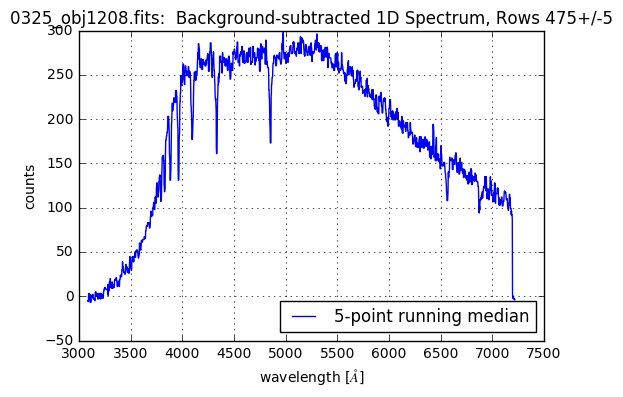

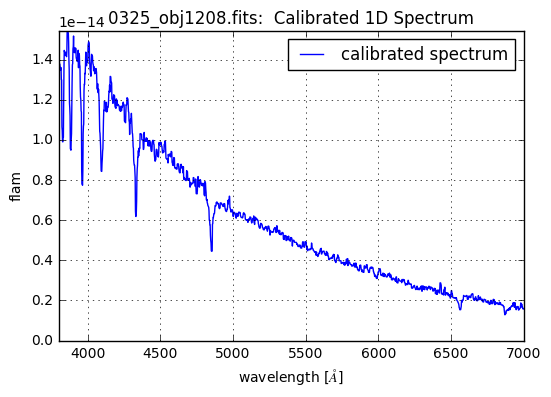

In [5]:
############################################################################
#
# Deal with Goodman configuration...
#
#############################################################################

# Effective dispersion for this grating and binning...
dispersion = binSize_wave*dispersion_nonbinned[grating]
# Wavelength corresponding to spectrum bin 0:
wavelength0 = wave1 - dispersion*col1  # Will typically be around 3100 for "400_WD" configuration


#############################################################################
#
# Deal with observed spectrum...
#
#############################################################################

inputFile = t_inputFile
calibFile = ss_inputFile+'.calib.csv'
outputFile = inputFile+'.1d_calib.csv'

aper_row_min = t_aper_row_center - t_delta_aper_row
aper_row_max = t_aper_row_center + t_delta_aper_row
small_plot_row_min = t_aper_row_center - t_delta_plot_row
small_plot_row_max = t_aper_row_center + t_delta_plot_row

image_data = fits.getdata(inputFile)

print('Min:', np.min(image_data))
print('Max:', np.max(image_data))
print('Mean:', np.mean(image_data))
print('Stdev:', np.std(image_data))

vmin = np.mean(image_data) - np.std(image_data)
vmax = np.mean(image_data) + 2.*np.std(image_data)

plt.figure(1)
plt.imshow(image_data, cmap='gray', vmin=vmin, vmax=vmax)
plt.xlabel("Column Number [pixels]")
plt.ylabel("Row Number [pixels]")
title="""%s:  Raw 2D Spectrum""" % (os.path.basename(inputFile))
plt.title(title)

plt.figure(2)
plt.imshow(image_data[small_plot_row_min:small_plot_row_max,:], 
           cmap='gray', vmin=vmin, vmax=vmax)
plt.xlabel("Column Number [pixels]")
title="""%s:  Raw 2D Spectrum, Rows %d+/-%d""" % \
    (os.path.basename(inputFile), t_aper_row_center, t_delta_plot_row)
plt.title(title)

median1d = np.median(image_data[small_plot_row_min:small_plot_row_max,:],axis=0)

bkg_data = np.tile(median1d,[948,1])

new_image_data = image_data-bkg_data

vmin = 0.00 - np.std(image_data)
vmax = 0.00 + 2.*np.std(image_data)


plt.figure(3)
plt.imshow(new_image_data[small_plot_row_min:small_plot_row_max,:], 
           cmap='gray', vmin=vmin, vmax=vmax)
plt.xlabel("Column Number [pixels]")
title="""%s:  Background-subtracted 2D Spectrum, Rows %d+/-%d""" % \
    (os.path.basename(inputFile), t_aper_row_center, t_delta_plot_row)
plt.title(title)


sum1d = np.sum(new_image_data[aper_row_min:aper_row_max,:],axis=0)

#x=np.arange(0,2071)
x=np.arange(0,sum1d.size)


# Running median...
x_series = pd.Series(x, name='x')
sum1d_series = pd.Series(sum1d, name='counts')
df_sum1d = pd.concat([x_series,sum1d_series], axis=1)
df_sum1d.loc[:,'wavelength'] = dispersion*df_sum1d.loc[:,'x'] + wavelength0
wave = df_sum1d.wavelength.values
df_sum1d_smoothed = df_sum1d.rolling(5).median().dropna()
x_smoothed = df_sum1d_smoothed.x.values
wave_smoothed = df_sum1d_smoothed.wavelength.values
sum1d_smoothed = df_sum1d_smoothed.counts.values


plt.figure(4)
plt.plot(x, sum1d, 'g-', 
         x_smoothed, sum1d_smoothed, 'y-')
plt.legend(['original spacing', 
            '5-point running median'], 
           loc='best')
plt.xlabel("""column # [pixel]""")
plt.ylabel("counts")
title="""%s:  Background-subtracted 1D Spectrum, Rows %d+/-%d""" % \
    (os.path.basename(inputFile), t_aper_row_center, t_delta_aper_row)
plt.title(title)
plt.grid(True)

plt.figure(5)
plt.plot(wave_smoothed, sum1d_smoothed, 'b-')
plt.legend(['5-point running median'], 
           loc='best')
plt.xlabel("""wavelength [$\AA$]""")
plt.ylabel("counts")
title="""%s:  Background-subtracted 1D Spectrum, Rows %d+/-%d""" % \
    (os.path.basename(inputFile), t_aper_row_center, t_delta_aper_row)
plt.title(title)
plt.grid(True)

df_sum1d_smoothed.to_csv(outputFile, index=False)


#############################################################################
#
# Read in calibFile and apply the spectrophotometric calibration...
#
#############################################################################

df_calib = pd.read_csv(calibFile)

calib_interp = interpolate.interp1d(df_calib.wave.tolist(), 
                                    df_calib.calib.tolist(),  
                                     bounds_error=False, fill_value=0., 
                                     kind='linear')


df_sum1d_smoothed.loc[:,'Flam'] =  df_sum1d_smoothed.loc[:,'counts'] * calib_interp(wave_smoothed)
sum1d_smoothed_calib = df_sum1d_smoothed.Flam.values

wavelo=3800.
wavehi=7000.
mask = ((df_sum1d_smoothed.wavelength >= 3500.) & (df_sum1d_smoothed.wavelength <= 7000.))
fluxhi = df_sum1d_smoothed[mask].Flam.max()

plt.figure(6)
plt.plot(wave_smoothed, sum1d_smoothed_calib, 'b-') 
plt.legend(['calibrated spectrum'], 
           loc='best')
plt.xlim(wavelo, wavehi)
plt.ylim(0.00,fluxhi)
plt.xlabel("""wavelength [$\AA$]""")
plt.ylabel('flam')
title="""%s:  Calibrated 1D Spectrum""" % (os.path.basename(inputFile))
plt.title(title)
plt.grid(True)


wave_series = pd.Series(wave_smoothed, name='wave')
calib_series = pd.Series(sum1d_smoothed_calib, name='flam')
df_calib = pd.concat([wave_series,calib_series], axis=1)
df_calib.to_csv(outputFile,index=False)

print 
print
print """* * * Calibrated 1d Spectrum written to %s * * *""" % (outputFile)
print
print